# Promiscuity Score Prediction
Necessary Input Changes are noted in in-code annotations

The promiscuity score indicator is built to provide additional insights into the 8-mer peptides generated by the TransformerBeta mdel developed by Aprile, Bravi and Zhao (2024)[1]. 

When provided with the .csv file generated as an output by TransformerBeta, a cascade-based model architecture will determine the likelihood of binding off-target.

The promiscuity score is calculated based on the number of predicted interactions with a high probability of binding




[1]: https://doi.org/10.48550/arXiv.2410.16302)

In [52]:
#Necessary import for the model

import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import RandomOverSampler

In [24]:
#Necessary imports for model evaluation

import torch
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    r2_score,
    mean_squared_error,
    make_scorer,
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    mean_absolute_error
)
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score

In [25]:
#Dictionary of a mino acid properties. Each entry follows the format:
#'[amino acid]' : [hydrophobicity, molecular weight, charge, pKa, polarity]
# note polarity score is 1 for nonpolar, 2 for uncharged polar and 3 for basic 

aa_properties = {
    'A': [1.8, 89.1, 0, 6.0, 1],
    'R': [-4.5, 174.2, +1, 10.8, 3], 
    'N': [-3.5, 132.1,  0,  5.4, 2],
    'D': [-3.5, 133.1, -1,  2.8, 2],
    'C': [2.5,  121.2,  0,  5.1, 1],
    'E': [-3.5, 147.1, -1,  3.2, 2],
    'Q': [-3.5, 146.2,  0,  5.7, 2],
    'G': [-0.4, 75.1,   0,  5.9, 1],
    'H': [-3.2, 155.2, +1,  7.6, 2],
    'I': [4.5,  131.2,  0,  6.0, 1],
    'L': [3.8,  131.2,  0,  6.0, 1],
    'K': [-3.9, 146.2, +1,  9.7, 3],
    'M': [1.9,  149.2,  0,  5.7, 1],
    'F': [2.8,  165.2,  0,  5.5, 1],
    'P': [-1.6, 115.1,  0,  6.3, 1],
    'S': [-0.8, 105.1,  0,  5.7, 2],
    'T': [-0.7, 119.1,  0,  5.6, 2],
    'W': [-0.9, 204.2,  0,  5.9, 1],
    'Y': [-1.3, 181.2,  0,  5.7, 2],
    'V': [4.2,  117.1,  0,  6.0, 1]
}

### Training Data Processing

Code used to generate the training data. 

This cell *does not need to be run* if 'model_training_data.csv' is available/generated.

In [57]:
#Training data processing, insertion of negative binding pairs to prevent overfitting of high binding interactions

training_data = np.load('train_data.npy', allow_pickle = True).item()
random.seed(42)
np.random.seed(42)

positive_pairs = []
negative_pairs = set()

for epitope, binders in training_data.items():
    for binder, count in binders.items():
        positive_pairs.append((epitope, binder, count))
random.shuffle(positive_pairs)
positive_pairs = positive_pairs[:5000] #5000 random entries to lighten computational demand; this can be adjusted

all_binders = list({b for binders in training_data.values() for b in binders})
epitope_list = list(training_data.keys())

#Generates negative binding pairs / decoys
while len(negative_pairs) < 2500:
    epitope = random.choice(epitope_list)
    binder = random.choice(all_binders)
    if binder not in training_data[epitope]:
        negative_pairs.add((epitope, binder, 0))

def filter_8mers(pairs):
    return [(epitope, binder, label) for epitope, binder, label in pairs if len(epitope) == 8 and len(binder) == 8]

positive_pairs = filter_8mers(positive_pairs)
negative_pairs = filter_8mers(list(negative_pairs))

all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

training_df = pd.DataFrame(all_pairs, columns = ['epitope', 'binder', 'label'])
print(training_df['label'].value_counts())
training_df.to_csv('model_training_data.csv', index = False)

0      2500
5      1126
6       780
7       501
8       346
       ... 
100       1
180       1
95        1
311       1
164       1
Name: label, Length: 169, dtype: int64


## Creating and Running the Model

The amino acid sequences are featurised so that each amino acid is represented by a vector of its 5 properties as laid out in earlier cells. 

A Random Forest Classifier (referred to as 'model' in-code) is trained on the featurised extracted training data containing both segments of the larger training_data.npy and manually generated decoys.

A Gradient Booster model then takes postitive results from the RF (i.e. likely binders) and calculates the binding score for each epitope-binder interaction it recieves.

In [ ]:
def featurise(seq):
    features = []
    for aa in seq:
        if aa in aa_properties:
            features.extend(aa_properties[aa])
        else:
            features.extend([0, 0, 0, 0, 0])
    return features

training_df = pd.read_csv('model_training_data.csv')
X = [featurise(epi) + featurise(binder) for epi, binder in zip(training_df['epitope'], training_df['binder'])]
y = training_df['label'].values.astype(float)
y_bin = (training_df['label'] > 0).astype(int)

y_clipped = np.clip(y, 0, 8).astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

resampled distribution: [2593    0    0    0    0 2593 2593 2593 2593]


In [59]:
#trains the Random Forest Classifier on now-featurised data
X_train, X_test, y_train, y_test, y_bin_train, y_bin_test = train_test_split(X_scaled, y, y_bin, test_size = 0.2, random_state= 42)
model = RandomForestClassifier(n_estimators= 200, random_state= 42, class_weight='balanced')
model.fit(X_train, y_bin_train)
print(training_df['label'].value_counts())

0      2500
5      1126
6       780
7       501
8       346
       ... 
100       1
180       1
95        1
311       1
164       1
Name: label, Length: 169, dtype: int64


In [62]:
#trains the Gradient Boosting Classifier]
#predicts the binding affinity of positive pairs only
positive_i = [i for i, label in enumerate(y_bin_train) if label == 1]
X_filtered_count = [X_scaled[i] for i in positive_i]
y_filtered_count = np.clip(y[positive_i], 0, 8).astype(int)

X_train_count, X_val_count, y_train_count, y_val_count = train_test_split(
    X_filtered_count, y_filtered_count, test_size=0.2, random_state=42, stratify = y_filtered_count
)

classifier = GradientBoostingClassifier(n_estimators = 200, random_state=42)
classifier.fit(X_train_count, y_train_count)

y_pred_count = classifier.predict(X_val_count)

## Using the Model

To use this pipeline, an accurate file path must be provided for des_peptide_df. By default, it only takes the top 10 entries but this can also be changed.

The binding promiscuity is calculated for each entry in the provided input csv. If these are not stored in a column titled 'Designed Complementary Peptide' this must also be altered.

To manually alter the threshold for what is considered a 'high binder', the line: 'if prob_binder >= 0.5' can be used to adjust this.

Please ensure that the file path for saving the output .csv file is accurate. \
A standard run takes approximately 4 mins per prediction

In [36]:
#Change file path to needed output file from TransformerBeta
des_peptide_df = pd.read_csv('output_analysis_PKHNSNRQ_100_rank.csv').head(10)
unique_training_df = training_df['epitope'].unique() #Stops duplicates in the data

In [65]:
#Predicts binding promiscuity of designed peptides
promiscuity_results = []
all_predictions = []
for des_peptide in tqdm(des_peptide_df['Designed Complementary Peptide'], desc = 'Peptide'):
    high_binding_score = []
    # Featurise the designed peptide
    for epitope in tqdm(unique_training_df, desc = 'Epitopes', leave = False):
        pair_features = featurise(epitope) + featurise(des_peptide)
        if len(pair_features) != 80:
            print(f'Error with epitope {epitope}, less than 80 features')
            continue

        #Predicts binding using models
        X_pair = [pair_features]
        X_pair_scaled = scaler.transform(X_pair)
        is_binder = model.predict(X_pair_scaled)[0]
        prob_binder = model.predict_proba(X_pair_scaled)[0][1]

        all_predictions.append({
            'binder':des_peptide,
            'target': epitope,
            'probability': prob_binder
        })

        if is_binder == 0:
            continue

        # Only consider pairs with a high probability of binding
        if prob_binder >= 0.3: # <-- threshold for what is considered a high binding score
            predicted_count = classifier.predict(X_pair_scaled)[0]
            predicted_count = np.clip(predicted_count, 0, 8)
            high_binding_score.append(predicted_count)

    total_epitopes = len(unique_training_df)
    num_high_hits = len(high_binding_score)
    promiscuity_score = round((num_high_hits/total_epitopes) * 100, 2)
    promiscuity_score = promiscuity_score / 100

    promiscuity_results.append({
        'Designed Peptide': des_peptide,
        'Predicted High-Binding Count': num_high_hits,
        'Promiscuity Score': promiscuity_score
    })

results_df = pd.DataFrame(promiscuity_results)
predictions_df = pd.DataFrame(all_predictions)
#Change this to necessary output file location
results_df.to_csv("./0.3_threshold_results/0.3_scores.csv", index = False)
print(results_df.head(5))

Peptide: 100%|██████████| 10/10 [56:41<00:00, 340.15s/it] 


  Designed Peptide  Predicted High-Binding Count  Promiscuity Score
0         LTIETDLL                          6655             0.8903
1         LSWSITVT                          7257             0.9708
2         LTLRIITQ                          7251             0.9700
3         VSWYSETY                          7409             0.9912
4         LWGAITLR                          7379             0.9872


## Model Performance Evaluation

The Promiscuity model is evaluated via the following metrics with accompanying scores:

Multi-Class Accuracy: \
Weighted F1-Score: \
Mean Absolute Error: \ 


In [69]:
y_clipped = np.clip(y, 0, 8).astype(int)
X_train, X_val, y_train_mc, y_val_mc = train_test_split(
    X_scaled, y_clipped, test_size=0.2, random_state=42, stratify=y_clipped
)
y_pred_count  = classifier.predict(X_val_count)

acc = accuracy_score(y_val_count, y_pred_count)
f1 = f1_score(y_val_count, y_pred_count, average='weighted')
report = classification_report(y_val_count, y_pred_count, digits = 3, zero_division = 1)
cm = confusion_matrix(y_val_count, y_pred_count)
mae = mean_absolute_error(y_val_count, y_pred_count)

print("Multi-Class Accuracy:", acc)
print('Weighted F1-Score:', f1)
print('\n Classification Report: \n', report)
print('\n Confusion Matrix: \n:', cm)
print('Mean Absolute Error:', mae)

Multi-Class Accuracy: 0.38172715894868586
Weighted F1-Score: 0.3354324150008102

 Classification Report: 
               precision    recall  f1-score   support

           0      0.434     0.566     0.491       272
           5      0.220     0.076     0.113       118
           6      0.111     0.024     0.039        85
           7      0.000     0.000     0.000        49
           8      0.369     0.509     0.428       275

    accuracy                          0.382       799
   macro avg      0.227     0.235     0.214       799
weighted avg      0.319     0.382     0.335       799


 Confusion Matrix: 
: [[154  10   4   2 102]
 [ 47   9   4   1  57]
 [ 30   3   2   1  49]
 [ 17   0   1   0  31]
 [107  19   7   2 140]]
Mean Absolute Error: 3.3516896120150186


In [71]:
y_pred_prob = model.predict_proba(X_scaled)[:,1]
y_pred_class = model.predict(X_scaled)
y_bin = (y > 0).astype(int)
#y_filtered_reg_train = np.array([y_train[i] for i in positive_i])

auroc = roc_auc_score(y_bin, y_pred_prob)
auprc = average_precision_score(y_bin, y_pred_prob)
report = classification_report(y_bin, y_pred_class, zero_division = 1)
cm = confusion_matrix(y_bin, y_pred_class)

y_pred_gb = classifier.predict(X_train_count)
r2 = r2_score(y_train_count, y_pred_gb)
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cross_val_r2 = cross_val_score(classifier, X_train_count, y_train_count, cv = 5, scoring = 'r2')
rmse = mean_squared_error(y_train_count, y_pred_gb, squared = False)
cross_val_rmse = cross_val_score(classifier, X_train_count, y_train_count, cv = 5, scoring = rmse_scorer)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Model R2: {r2:.4f}, RMSE: {rmse:.4f}')
print(f"Train R²: {r2:.4f}, Train RMSE: {rmse:.4f}")
print(f"CV R²: {np.mean(cross_val_r2):.4f}, CV RMSE: {np.mean(cross_val_rmse):.4f}")
print(report)


AUROC: 0.9858
AUPRC: 0.9927
Model R2: 0.5329, RMSE: 2.3426
Train R²: 0.5329, Train RMSE: 2.3426
CV R²: -1.0900, CV RMSE: 4.9547
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      2500
           1       0.91      1.00      0.95      5000

    accuracy                           0.93      7500
   macro avg       0.95      0.90      0.92      7500
weighted avg       0.94      0.93      0.93      7500



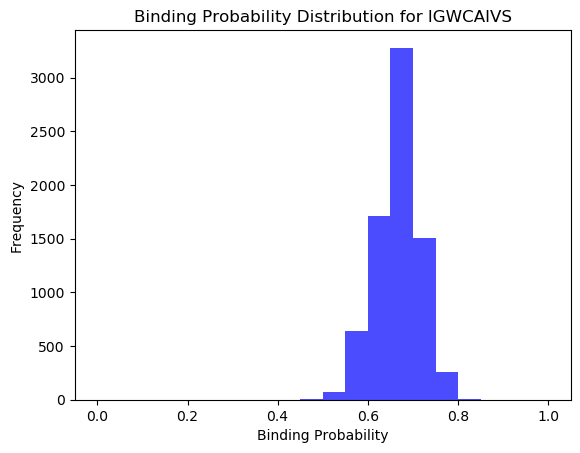

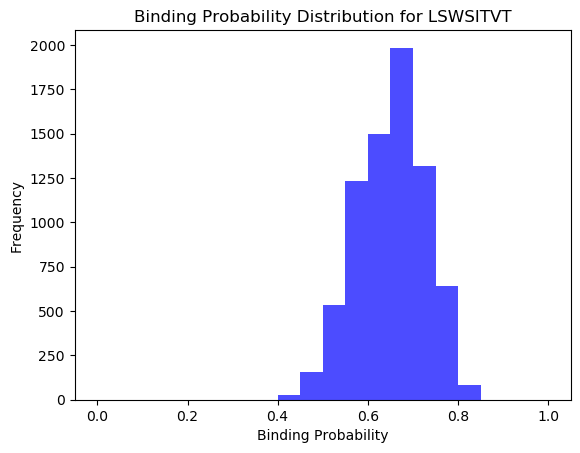

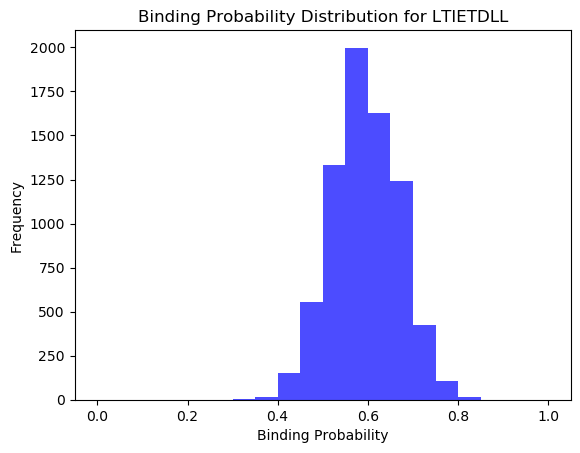

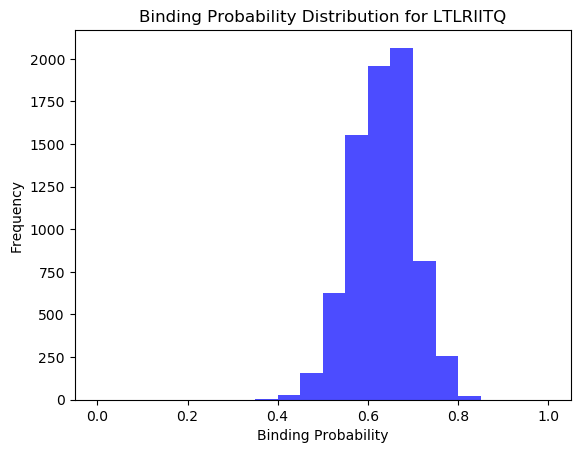

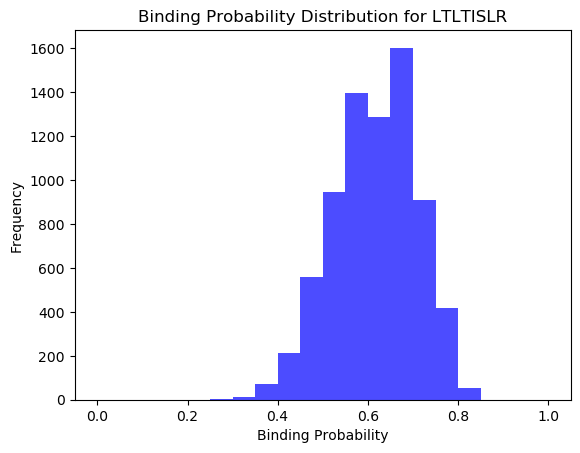

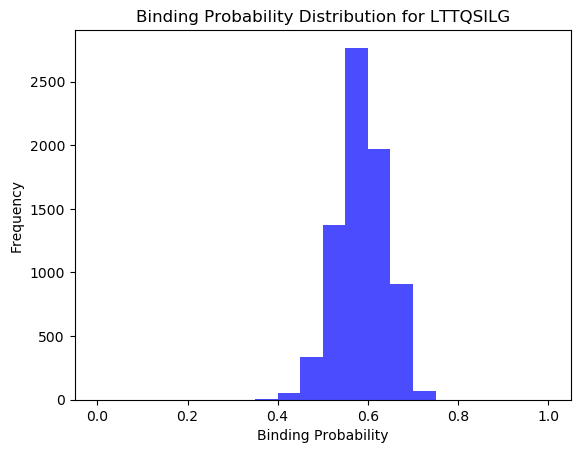

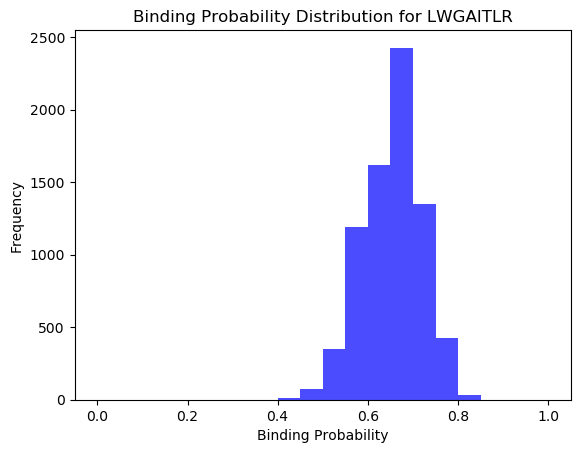

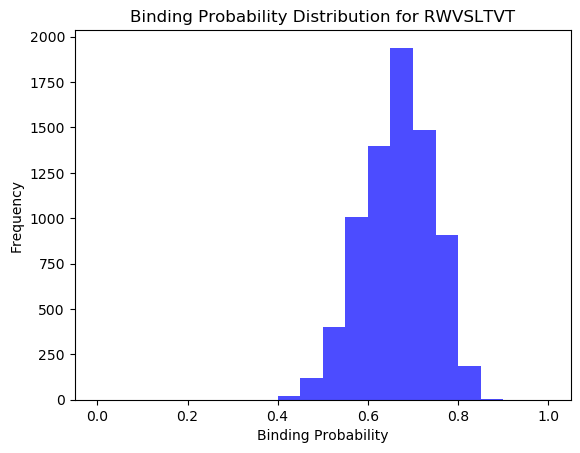

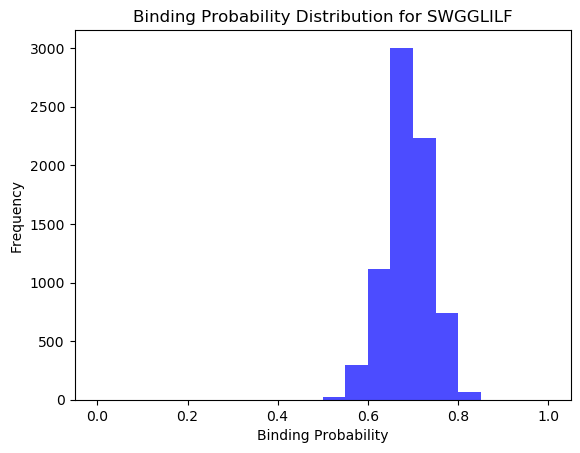

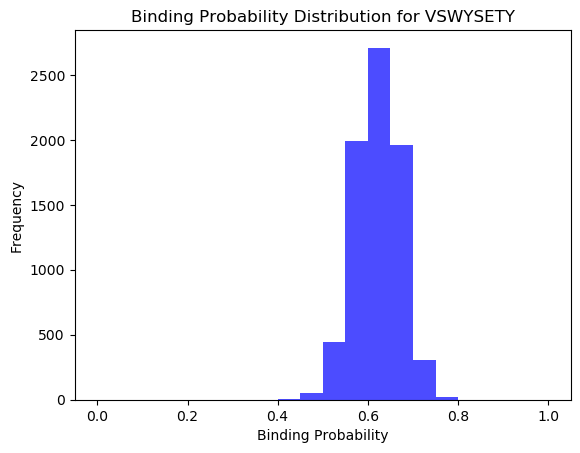

In [67]:
#Generates histograms of binding probabilities for a binder; this helps visualise the distribution of binding probabilities for each binder
prob_threshold = 0.5
promiscuity_cutoff = 5 #threshold for number of targets needed to be considered promiscuous

promiscuity_counts = (
    predictions_df[predictions_df['probability'] >= prob_threshold]
    .groupby('binder')['target']
    .nunique()
    .reset_index(name = 'high_prob_epitope_count')
)
os.makedirs('./0.3_threshold_results', exist_ok = True)

for binder in promiscuity_counts['binder']:
    binder_probs = predictions_df[predictions_df['binder'] == binder]['probability']
    plt.figure()
    plt.hist(binder_probs, bins = 20, range = (0, 1), alpha = 0.7, color = 'blue')
    plt.title(f'Binding Probability Distribution for {binder}')
    plt.xlabel('Binding Probability')
    plt.ylabel('Frequency')
    file = os.path.join('./0.3_threshold_results', f'{binder}_binding_probabilities.png')
    plt.savefig(file, dpi= 300, bbox_inches='tight')